<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 1</h1>

**Learn to develop your own architecture for image classification task**

# Getting the data
Using CIFAR 10 

In [0]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [0]:
cifar_10 = keras.datasets.cifar10.load_data()

In [3]:
train_all, test = cifar_10
X_train_all,y_train_all = train_all
X_test, y_test = test
X_train,X_valid,y_train,y_valid = train_test_split(X_train_all,y_train_all,train_size=0.9,stratify=y_train_all)

class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
    'ship', 'truck'
]

sets = ['tr','va','te']
TR,VA,TE = sets

# Scale images from 0 to 1
X = {s:d.copy()/255 for s,d in zip(sets,[X_train,X_valid,X_test])}
y = {s:d.copy().squeeze() for s,d in zip(sets,[y_train,y_valid,y_test])}


print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(45000, 32, 32, 3) (45000, 1) (5000, 32, 32, 3) (5000, 1) (10000, 32, 32, 3) (10000, 1)


**View the data**

In [0]:
import numpy as np
import matplotlib.pyplot as plt

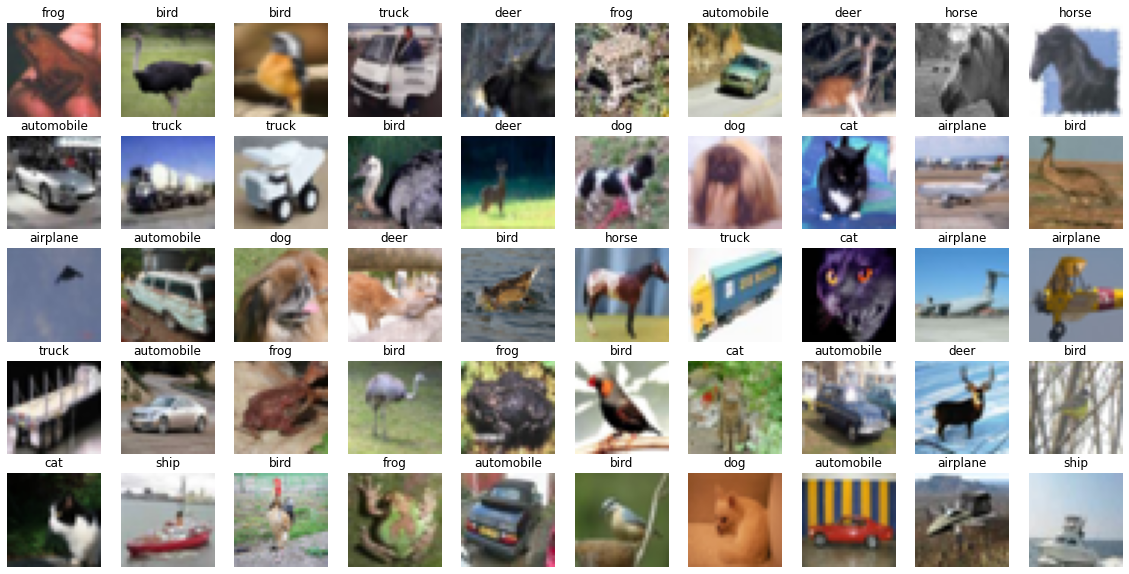

In [5]:
r,c = 5,10
plt.figure(figsize=(20,10))

r_idx = np.random.randint(0,len(y_train),(r*c,))
for i in range(r*c):
    idx = r_idx[i]
    label = class_labels[y_train[idx].item()]
    plt.subplot(r,c,i+1)
    plt.imshow(X_train[idx])
    plt.axis('off')
    plt.title(label)
plt.show() 

# Create Dataset and Dataloader
For use with pytorch

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [0]:
tf = lambda d: torch.tensor(d, dtype=torch.float32)
ti = lambda d: torch.tensor(d, dtype=torch.long)

dl = {s: DataLoader(TensorDataset(tf(X[s].transpose(0,3,1,2)), ti(y[s])),batch_size=64,shuffle=True) for s in sets}

___

# Define a network

## Pytorch Implementation

In [0]:
import time
from copy import deepcopy

from torch import nn
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

Tesla P100-PCIE-16GB
(6, 0)


### Model Definition

In [0]:
class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride,padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BasicConv(3, 32, 7)
        self.maxp1 = nn.MaxPool2d(3, 1)
        self.conv2 = BasicConv(32, 96, 1)
        self.conv3 = BasicConv(96, 192, 3)
        self.maxp2 = nn.MaxPool2d(3, 1)

    def forward(self, x):
        x = self.conv1(x)  # (32,26,26)
        x = self.maxp1(x)  # (32,24,24)
        x = self.conv2(x)  # (96,24,24)
        x = self.conv3(x)  # (192,22,22)
        x = self.maxp2(x)  # (192,20,20)
        return x
    
class IncepSkipBlock(nn.Module):
    def __init__(self, in_channel, out_channels):
        super().__init__()
        self.branch0 = BasicConv(in_channel, out_channels[0], 1)

        self.branch1 = nn.Sequential(
            BasicConv(in_channel, out_channels[1], 1,padding=1),
            BasicConv(out_channels[1], out_channels[3], 3)
        )

        self.branch2 = nn.Sequential(
            BasicConv(in_channel, out_channels[2], 1, padding=2),
            BasicConv(out_channels[2], out_channels[4], 5)
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, 1,padding=1),
            BasicConv(in_channel, out_channels[5], 1)
        )

    def forward(self, x):
        x_0 = self.branch0(x)
        x_1 = self.branch1(x)
        x_2 = self.branch2(x)
        x_3 = self.branch3(x)
        x = torch.cat([x,x_0,x_1,x_2,x_3],dim=1)
        return x
        
class LameNet(nn.Module):
    def __init__(self,classes=10):
        super().__init__()
        self.stem = Stem()
        self.block1 = IncepSkipBlock(192,[32,64,16,96,32,32])
        self.pblock1 = nn.Sequential(
            BasicConv(384,256,1),
            nn.MaxPool2d(3,2)
        )
        self.drop_1 = nn.Dropout2d(p=0.8)
        self.block2 = IncepSkipBlock(256,[64,128,32,192,64,64])
        self.pblock2 = nn.Sequential(
            BasicConv(640,512,1),
            nn.MaxPool2d(3,2)
        )
        self.conv3_1 = BasicConv(512,1024,3,1)
        self.drop_2 = nn.Dropout2d(p=0.6)
        self
        self.linear = nn.Linear(4096,classes)
        self.logits = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.pblock1(x)
        x = self.drop_1(x)
        x = self.block2(x)
        x = self.pblock2(x)
        x = self.conv3_1(x)
        x = self.drop_2(x)
        x = self.linear(x.view(x.size(0),-1))
        x = self.logits(x)
        return x

### Helper Functions

#### Function to check accuracy

In [0]:
def check_accu(model, dl_test, verbose=True):
    model = model.to(device)
    model.eval()
    
    bs = dl_test.batch_size
    size = len(dl_test.dataset)
    batch_count = size//bs
    
    corrects = 0
    losses = 0
    percent = 0
    if verbose:
        print(f"batches ({batch_count}): ",end="\n\t")
    for i,batch in enumerate(dl_test):
        with torch.no_grad():
            X,y = batch
            if verbose:
                print(str(i).rjust(len(str(batch_count))+1),end="")
                if ((i+1) % 25) == 0:
                    print(end="\n\t")

            b = len(y)
            X = X.to(device)
            y = y.to(device)
            y_ = model(X)

            losses += loss_func(y_,y).item() * b
            corrects += (y_.argmax(dim=1)==y).sum().item()
    loss, accu = losses/size, corrects/size
    if verbose:
        print(f"\nloss: {loss:0.4f} accuracy: {accu:0.4f}")
    return loss, accu

#### Fit Function

In [0]:
def fit(model, optim, sched, loss_func, dl, epochs=1, is_test=False):
    model = model.to(device)

    # Test batch multipliers
    tb_t,tb_v = 6,2

    # To switch between training and validation
    phases = [TR, VA]

    # Measure total time
    tot_time = time.time()

    # Record metrics
    losses = {TR:[], VA:[]}
    accuracies = {TR:[], VA:[]}

    # Dataset sizes for accu and loss calcualtions
    sizes = {ph: len(dl[ph].dataset) for ph in phases}
    if is_test:
        sizes[TR] = tb_t * dl[TR].batch_size
        sizes[VA] = tb_v * dl[VA].batch_size
    
    # Init markers
    least_loss = float('inf')
    best_accu = 0
    best_model = deepcopy(model.state_dict())
    
    for e in range(epochs):
        # Measure the epoch time (train + valid)
        epo_time = time.time()

        # Print epoch counter
        epoch_st = f"[{e+1}/{epochs}]".rjust(len(str(epochs))*2+3)
        print(f"{epoch_st} | ",end="")
        
        for phase in phases:
            # Running metrics, caluclate as they come in
            running_loss = 0
            running_corr = 0

            # bool checker used ahead for updating markers and optimizer step
            is_tr = phase == TR

            # Iterate over training or validation batch
            for b_num,batch in enumerate(dl[phase]):

                # Limit batches if testing fit function
                if is_test:
                    if is_tr:
                        if b_num == tb_t:
                            break
                    elif not is_tr and b_num == tb_v:
                        break
                    else:
                        pass

                # Get data and batch size
                X,y = batch
                bs = y.size(0)
                
                # Shift data to device (when GPU)
                X = X.to(device)
                y = y.to(device)
                    
                # Reset gradients to zero
                optim.zero_grad()
                
                # Sets model.eval or model.train depending on bool
                with torch.set_grad_enabled(is_tr):

                    # Forward pass 
                    y_pred = model(X)

                    # Calculate loss using loss_function 
                    loss = loss_func(y_pred,y)

                    # Update weights only if trianing phase
                    if is_tr:
                        loss.backward()
                        optim.step()
                        
                    # Update lr if validation loss don't change none
                    if not is_tr:
                        sched.step(loss)
                
                # Deaverage the loss and get correct predictions
                batch_loss = loss.item() * bs
                batch_corr = (y_pred.argmax(dim=1) == y).sum().item()
                # Add to running metrics
                running_loss += batch_loss
                running_corr += batch_corr

            # Calculate epochal loss and accu
            epo_loss = running_loss / sizes[phase]
            epo_accu = running_corr / sizes[phase]
            
            # Print epochal metrics
            print(f"{phase} :: loss: {epo_loss:0.4f} accu: {epo_accu:0.4f} | ", end="")
            
            # Store metrics
            losses[phase].append(epo_loss)
            accuracies[phase].append(epo_accu)
            
            # Update markers if not training
            if not is_tr:
                if epo_accu > best_accu:
                    best_accu = epo_accu
            
                if epo_loss < least_loss:
                    least_loss = epo_loss
                    best_model = deepcopy(model.state_dict())
            
        # Print time taken by epoch
        end_time = np.round(time.time() - epo_time,3)
        s,ms = str(end_time).split('.')
        print(f"time {s} s {ms} ms")

    # Restore "best" model, print total time and metrics.
    model.load_state_dict(best_model)
    end_time = np.round(time.time() - tot_time,3)
    s,ms = str(end_time).split('.')
    print(f"best accuracy: {best_accu:0.4f} least loss: {least_loss:0.4f}")
    print(f"time {int(s)//60} m {int(s)%60} s {ms} ms")

    return losses, accuracies

#### Optimal Learning Rate Finding Helpers

In [0]:
def simple_fit(model,dl,optim,loss_func,epoch=10):
    model = model.to(device)
    losses = []
    for e in range(epoch):
        r_loss = 0
        for X,y in dl:
            bs = y.size(0)
            X = X.to(device)
            y = y.to(device)

            optim.zero_grad()
            y_ = model(X)
            loss = loss_func(y_,y)
            loss.backward()
            optim.step()
            r_loss += loss.item() * bs
        losses.append(r_loss/len(dl.dataset))
    return losses

def net_tester(Model,dl,test_epochs,lr_list):
    losses_list = []
    metric_list = []
    for lr in lr_list:
        model = Model()
        loss_func = torch.nn.CrossEntropyLoss()
        optim = torch.optim.Adam(model.parameters(),lr=lr)

        # Obtain the metrics
        losses_ = simple_fit(model,dl,optim,loss_func,epoch=100)
        loss_, accu_ = check_accu(model,dl,False)

        # Store the metrics
        losses_list.append(losses_)
        metric_list.append((loss_,accu_))

        # Disply the metrics
        print(f"lr: {lr}\tloss: {loss_}   accu: {accu_}")
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(np.arange(len(losses_)),losses_)
        plt.show()
    return losses_list, metric_list

lr: 0.01	loss: 2.2892162799835205   accu: 0.171875


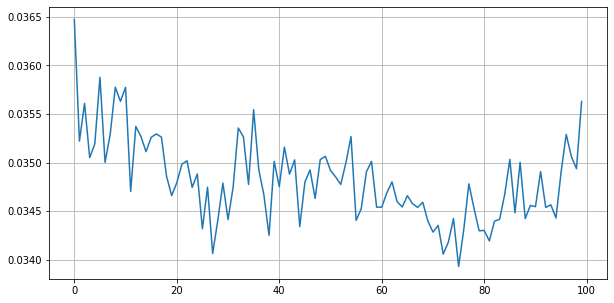

lr: 0.001	loss: 1.876776933670044   accu: 0.59375


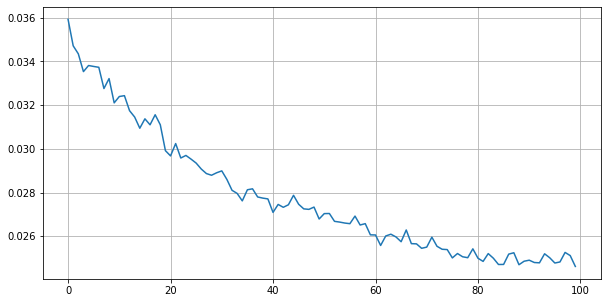

lr: 0.0005	loss: 1.76589035987854   accu: 0.6953125


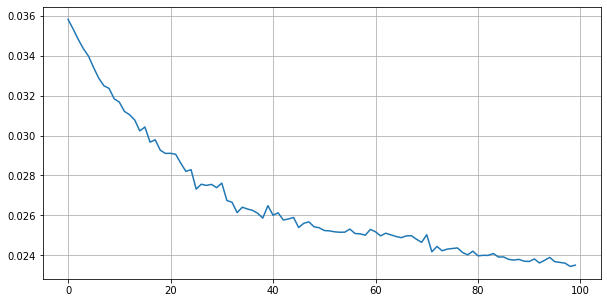

lr: 0.0001	loss: 2.031724452972412   accu: 0.40625


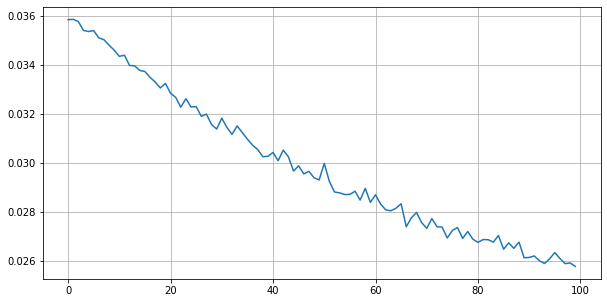

lr: 5e-05	loss: 2.1010234355926514   accu: 0.3359375


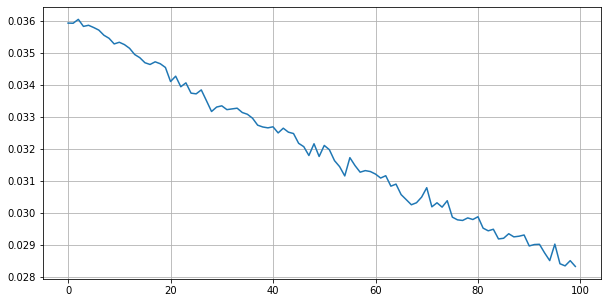

lr: 1e-05	loss: 2.2533161640167236   accu: 0.15625


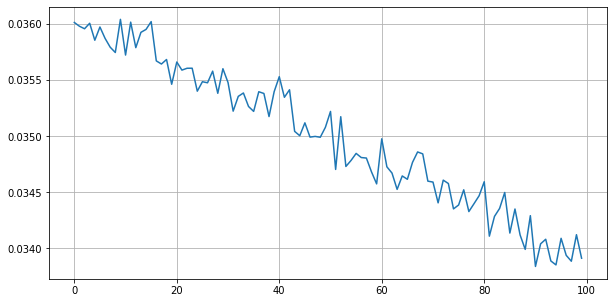

In [19]:
learning_rates = [0.01,0.001,0.0005,0.0001,0.00005,0.00001]
micro_sz = 128
dl_micro = DataLoader(TensorDataset(tf(X[TR][:micro_sz].transpose(0,3,1,2)), ti(y[TR][:micro_sz])),batch_size=64,shuffle=True)
losses_list, metric_list = net_tester(LameNet, dl_micro, 200,learning_rates)

### Fit
*Test run*

In [182]:
model_pt = LameNet()
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_pt.parameters(),lr=4e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, threshold=5e-5, patience=10)
dl_temp = {TR:dl_micro,VA:dl_micro}

_ = fit(model_pt, optim, sched, loss_func, dl_temp, epochs=10)

 [1/10] | tr :: loss: 2.3003 accu: 0.1328 | va :: loss: 2.2854 accu: 0.1328 | time 0 s 127 ms
 [2/10] | tr :: loss: 2.2733 accu: 0.1953 | va :: loss: 2.2437 accu: 0.2344 | time 0 s 121 ms
 [3/10] | tr :: loss: 2.2260 accu: 0.2734 | va :: loss: 2.2134 accu: 0.2891 | time 0 s 121 ms
 [4/10] | tr :: loss: 2.1942 accu: 0.3125 | va :: loss: 2.1789 accu: 0.3438 | time 0 s 126 ms
 [5/10] | tr :: loss: 2.2072 accu: 0.2578 | va :: loss: 2.1300 accu: 0.3750 | time 0 s 118 ms
 [6/10] | tr :: loss: 2.1344 accu: 0.3906 | va :: loss: 2.1289 accu: 0.3438 | time 0 s 118 ms
 [7/10] | tr :: loss: 2.1062 accu: 0.3672 | va :: loss: 2.0882 accu: 0.4141 | time 0 s 118 ms
 [8/10] | tr :: loss: 2.0838 accu: 0.3984 | va :: loss: 2.0922 accu: 0.4297 | time 0 s 108 ms
 [9/10] | tr :: loss: 2.0595 accu: 0.4219 | va :: loss: 2.0386 accu: 0.4375 | time 0 s 118 ms
[10/10] | tr :: loss: 2.0506 accu: 0.4453 | va :: loss: 2.0380 accu: 0.4531 | time 0 s 119 ms
best accuracy: 0.4531 least loss: 2.0380
time 0 m 1 s 21 ms


*Actual run*

In [0]:
losses, accuracies, best_weight = fit(model_pt, optim, sched, loss_func, dl, epochs=100, is_test=False)

### Test

In [0]:
check_accu(model_pt, dl[TE])

___

## Keras Implementation

In [0]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, activations, optimizers, losses, callbacks

In [21]:
print((tf.version.VERSION))
print(tf.config.list_physical_devices('GPU'))

2.2.0-rc3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Model Definition

In [0]:
def basic_conv(name, out_channels, kernel_size, stride=1, padding='valid'):
    return keras.Sequential([
        layers.Conv2D(out_channels,kernel_size, stride,padding,activation=None),
        layers.BatchNormalization(),
        layers.ReLU()
    ],name)

def stem():
    return keras.Sequential([
        basic_conv("conv_7_1",32,7),
        layers.MaxPool2D((3,3),1),
        basic_conv("conv_1_1",96,1),
        basic_conv("conv_3_1",192,3),
        layers.MaxPool2D((3,3),1)
    ],name="stem")

def incep_skip_block(input_shape, out_channels, name):
    branch0 = basic_conv("conv_1_1",out_channels[0],1)
    branch1 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[1],1),
        basic_conv("conv_1_2",out_channels[3],3, padding='same')
        
    ])
    branch2 = keras.Sequential([
        basic_conv("conv_1_2",out_channels[2],1),
        basic_conv("conv_1_2",out_channels[4],5, padding='same')
    ])
    branch3 = keras.Sequential([
        layers.MaxPool2D((3,3),strides=1,padding='same'),
        basic_conv("conv_1_2",out_channels[5],1)
    ])
    input_ = layers.Input(shape=input_shape)
    b0_out = branch0(input_)
    b1_out = branch1(input_)
    b2_out = branch2(input_)
    b3_out = branch3(input_)
    output_ = layers.concatenate([input_,b0_out,b1_out,b2_out,b3_out])
    return keras.Model(inputs=[input_],outputs=[output_],name=name)

def post_block(out_channels,name):
    return keras.Sequential([
        basic_conv("conv_1_1",out_channels,1),
        layers.MaxPool2D((3,3),2)
    ],name)

def lame_net(classes=10,name="lame_net"):
    input_ = layers.Input(shape=(32,32,3))
    stem_ = stem()(input_)
    
    isblock1 = incep_skip_block((20,20,192),[32,64,16,96,32,32],'incep_skip_1')(stem_)
    pblock1 = post_block(256,'pblock_1')(isblock1)
    
    dropout_1 = layers.Dropout(rate=0.2)(pblock1)

    isblock2 = incep_skip_block((9,9,256),[64,128,32,192,64,64],'incep_skip_2')(dropout_1)
    pblock2 = post_block(512,'pblock_2')(isblock2)
    
    conv3_1 = basic_conv("conv_3_1",1024,3)(pblock2)
    dropout_2 = layers.Dropout(rate=0.4,)(conv3_1)

    flatten = layers.Flatten()(dropout_2)
    softmax = layers.Dense(10,activation='softmax')(flatten)
    return keras.Model(inputs=[input_],outputs=[softmax],name=name)

In [23]:
model_ke = lame_net(10,"lame_net")
model_ke.summary()

Model: "lame_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stem (Sequential)            (None, 20, 20, 192)       175264    
_________________________________________________________________
incep_skip_1 (Model)         (None, 20, 20, 384)       97104     
_________________________________________________________________
pblock_1 (Sequential)        (None, 9, 9, 256)         99584     
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 256)         0         
_________________________________________________________________
incep_skip_2 (Model)         (None, 9, 9, 640)         348832    
_________________________________________________________________
pblock_2 (Sequential)        (None, 4, 4, 512)         330

**Compile the model**

In [0]:
model_ke.compile(
    optimizer=optimizers.Adam(learning_rate=4e-4),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

**Ready the data (alter shapes for keras)**

In [0]:
X_for_keras = lambda X:X.transpose(0,1,2,3)
y_for_keras = lambda y:y.squeeze()

X_ke = {s: X_for_keras(X[s]) for s in sets}
y_ke = {s: y_for_keras(y[s]) for s in sets}

**Callbacks**

In [0]:
lr_scheduler_cb = callbacks.ReduceLROnPlateau(factor=0.5, min_delta=5e-5, patience=5)
early_stopping_cb = callbacks.EarlyStopping(min_delta=0.01,patience=20,restore_best_weights=True)

**Fit**  

*test run just an epoch*

In [184]:
_ = model_ke.fit(x=X_ke[TR][:384],
                 y=y_ke[TR][:384],
                 validation_data=(X_ke[VA][:128], y_ke[VA][:128]),
                 batch_size=64,
                 epochs=9,
                 callbacks = [lr_scheduler_cb, early_stopping_cb])

Epoch 1/9
6/6 [==============================] - 0s 44ms/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 5.5151 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 2/9
6/6 [==============================] - 0s 34ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 5.6165 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 3/9
6/6 [==============================] - 0s 34ms/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 5.7075 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 4/9
6/6 [==============================] - 0s 34ms/step - loss: 0.0396 - accuracy: 0.9974 - val_loss: 5.7857 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 5/9
6/6 [==============================] - 0s 36ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 5.8536 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 6/9
6/6 [==============================] - 0s 35ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 5.9113 - val_accuracy: 0.1250 - lr: 5.0000e-06
Epoch 7/9
6/6 [==============================] - 0s 35ms/step - loss: 

*actual fit*

In [185]:
history = model_ke.fit(x=X_ke[TR],
                       y=y_ke[TR],
                       validation_data=(X_ke[VA], y_ke[VA]),
                       batch_size=64,
                       epochs=100,
                       callbacks=[lr_scheduler_cb, early_stopping_cb])

Epoch 1/100
704/704 [==============================] - 24s 34ms/step - loss: 2.1210 - accuracy: 0.3780 - val_loss: 2.4993 - val_accuracy: 0.3104 - lr: 2.5000e-06
Epoch 2/100
704/704 [==============================] - 23s 33ms/step - loss: 1.8403 - accuracy: 0.4127 - val_loss: 2.2488 - val_accuracy: 0.3364 - lr: 2.5000e-06
Epoch 3/100
704/704 [==============================] - 23s 33ms/step - loss: 1.7275 - accuracy: 0.4299 - val_loss: 2.0827 - val_accuracy: 0.3598 - lr: 2.5000e-06
Epoch 4/100
704/704 [==============================] - 23s 33ms/step - loss: 1.6459 - accuracy: 0.4503 - val_loss: 2.0586 - val_accuracy: 0.3570 - lr: 2.5000e-06
Epoch 5/100
704/704 [==============================] - 23s 33ms/step - loss: 1.5896 - accuracy: 0.4625 - val_loss: 2.0280 - val_accuracy: 0.3680 - lr: 2.5000e-06
Epoch 6/100
704/704 [==============================] - 23s 33ms/step - loss: 1.5393 - accuracy: 0.4762 - val_loss: 1.9914 - val_accuracy: 0.3798 - lr: 2.5000e-06
Epoch 7/100
704/704 [=======

KeyboardInterrupt: ignored

In [0]:
pd.DataFrameFrame(history.history).plot(figsize=(20, 10))
plt.grid(True)
plt.show()

**Testing the model**

In [0]:
te_loss,te_accuracy = model_ke.evaluate(x=X_ke[TE],y=y_ke[TE],batch_size=64,verbose=0)
print(f"testing → loss: {te_loss:0.4f}  accuracy: {te_accuracy:0.4f}")